In [1]:
import re

import pandas as pd
import torch
import os
import json
import numpy as np
import pickle
from pingouin import ttest
import tikzplotlib as tikz

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
def save_plot(path, fig):
    with open(path + ".pkl", 'wb') as file:
        pickle.dump(fig, file)
    fig.savefig(path + ".svg")

In [22]:
parent_path = "../neurips/"
plot_path = "../neurips/plots/"
run = '2'
approach = "lambdabeam"

In [23]:
with open(parent_path + f"{approach}/models{run}/model-best-valid.ckpt", "rb") as f:
    ckpt = torch.load(f)  # , map_location=torch.device("mps"))

In [24]:
inventions = ckpt["inventions"]
for inv in inventions:
    print(inv.name, inv.program, inv.arity)

In [25]:
constants = ckpt["domain"].constants
print(f"initial constants: {[-1, 1]}")
print(f"now: {constants}")

initial constants: [-1, 1]
now: [-1, 1]


In [26]:
with open(parent_path + f"{approach}/results{run}/run_1.json", "rb") as json_file:
    results = json.load(json_file)
solutions = [ele for ele in results["results"] if ele["success"]]
len(solutions) / len(results["results"]) * 100

38.0

43.99999976158142 37.99999952316284


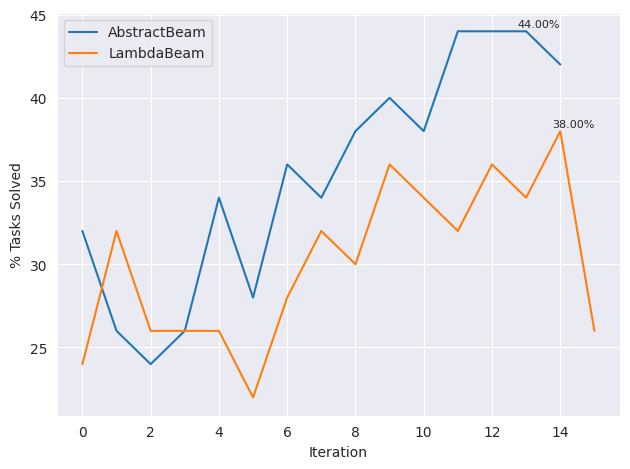

In [27]:
path_dict = {"dws-07": ["events.out.tfevents.1714053475.dws-07.3890530.0", "events.out.tfevents.1714032509.dws-07.3771435.0"],
             "dws-08": ["events.out.tfevents.1714457794.dws-08.391667.0"],
             "dws-16": ["events.out.tfevents.1714468183.dws-16.15788.0"],
             "dws-17": ["events.out.tfevents.1714468132.dws-17.15830.0"],
             "dws-06": ["events.out.tfevents.1713428257.dws-06.1874500.0", "events.out.tfevents.1713532162.dws-06.528186.0"],
             "dws-06-2": [""]}
# Path to your event file or directory
ab_file = f'../neurips/abstractbeam/models/logs/'
scalars_AB, times = [], []
for file in path_dict["dws-07"]: 
    # Initialize an event accumulator
    event_AB = EventAccumulator(ab_file + file)
    event_AB.Reload()
    scalars = event_AB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_AB += [ele.value for ele in scalars]

inds = np.argsort(times)
scalars_AB = np.array(scalars_AB)[inds] 

lb_file = parent_path + f'lambdabeam/models/logs/'
scalars_LB, times = [], []
for file in path_dict["dws-06"]: 
    # Initialize an event accumulator
    event_LB = EventAccumulator(lb_file + file)
    event_LB.Reload()
    scalars = event_LB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_LB += [ele.value for ele in scalars]
fig, ax = plt.subplots()
df = pd.DataFrame.from_dict({"AbstractBeam": np.array(list(scalars_AB) + [np.nan] * (16 - len(scalars_AB))) * 100, "LambdaBeam": np.array(list(scalars_LB) + [np.nan] * (16 - len(scalars_LB))) * 100})
sns.lineplot(df, x=np.arange(len(df)), y=df["AbstractBeam"], label="AbstractBeam")
ax.text(len(scalars_AB) - 1, max(df["AbstractBeam"])+0.1, f'{max(df["AbstractBeam"]):.2f}%', ha='right', va='bottom', fontsize=8)
sns.lineplot(df, x=np.arange(len(df)), y=df["LambdaBeam"], label="LambdaBeam")
ax.text(len(scalars_LB) - 1, max(df["LambdaBeam"])+0.1, f'{max(df["LambdaBeam"]):.2f}%', ha='right', va='bottom', fontsize=8)
ax.set_ylabel("% Tasks Solved")
ax.set_xlabel("Iteration")
# fig.legend()
fig.tight_layout()
# save_plot(plot_path + "performance_iteration", plt.gcf())
print(max(df["AbstractBeam"]), max(df["LambdaBeam"]))

In [19]:
from crossbeam.data.deepcoder.solution_weight import solution_weight
def load_and_process_results(file_paths, key="elapsed_time"):
    for file_path in file_paths:
        with open(file_path) as f:
            results = json.load(f)["results"]
        if key == "total_num_values_explored":
            num_programs, success = zip(*[(sol["stats"][key], sol["success"]) for sol in results if sol["stats"]["total_num_values_explored"] and sol["elapsed_time"] <= 100])
        else:
            if key == "elapsed_time":
                num_programs, success = zip(*[(sol["elapsed_time"], sol["success"]) for sol in results if sol["elapsed_time"] and sol["elapsed_time"] <= 100])
            
        sorted_data = sorted(zip(num_programs, success))
        sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)
        cumulative_tasks = [sum(sorted_tasks_solved[:i+1]) / len(results) * 100 for i in range(len(sorted_tasks_solved))]
        if key == "elapsed_time":
            sorted_time_taken = list(sorted_time_taken) + [100]
            cumulative_tasks.append(cumulative_tasks[-1])
        else:
            sorted_time_taken = list(sorted_time_taken)
        
    
    return sorted_time_taken, cumulative_tasks


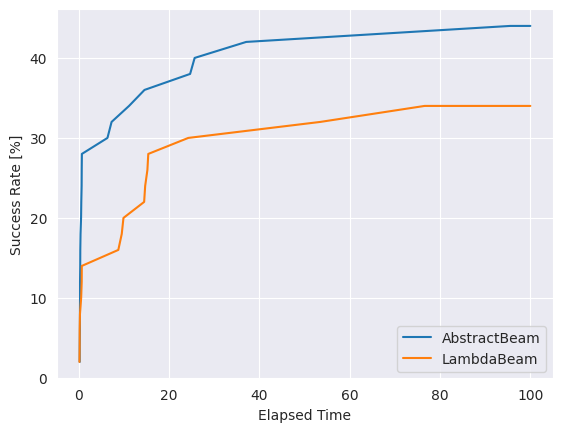

In [39]:
ax = plt.subplot()
x_axis, success_rate = load_and_process_results(['../neurips/abstractbeam/results/run_1.json'])
df_ab = pd.DataFrame.from_dict({"Elapsed Time": x_axis, "Success Rate [%]": success_rate})
x_axis, success_rate = load_and_process_results(['../neurips/lambdabeam/results/run_1.json'])
df_lb = pd.DataFrame.from_dict({"Elapsed Time": x_axis, "Success Rate [%]": success_rate})

sns.lineplot(df_ab, x="Elapsed Time", y="Success Rate [%]", label="AbstractBeam", ax=ax)
sns.lineplot(df_lb, x="Elapsed Time", y="Success Rate [%]", label="LambdaBeam", ax=ax)
# save_plot(plot_path + "performance_time", plt.gcf())

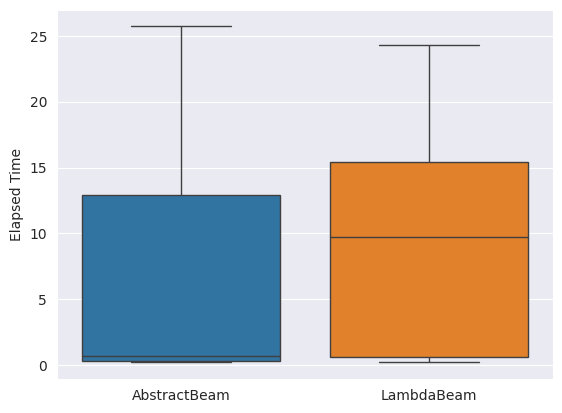

In [40]:
res = ttest(df_ab["Elapsed Time"], df_lb["Elapsed Time"])
df = pd.DataFrame.from_dict({"AbstractBeam": df_ab["Elapsed Time"], "LambdaBeam": df_lb["Elapsed Time"]})
ax = plt.subplot()
sns.boxplot(df, ax=ax, showfliers=False)
ax.set_ylabel("Elapsed Time")
df["AbstractBeam"].median()
# save_plot(plot_path + "boxplot_time", plt.gcf())

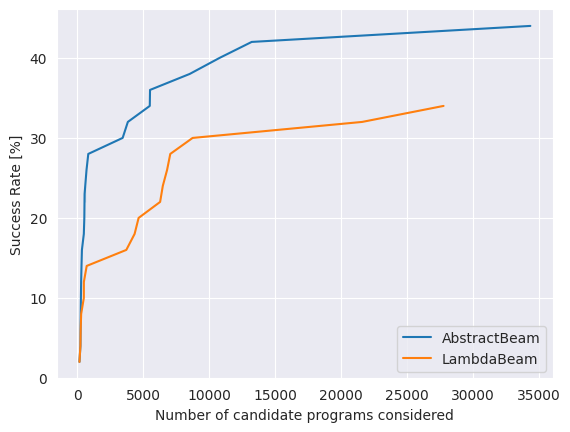

In [41]:
ax = plt.subplot()
x_axis, success_rate = load_and_process_results(['../neurips/abstractbeam/results/run_1.json'], key="total_num_values_explored")
df_ab = pd.DataFrame.from_dict({"Number of candidate programs considered": x_axis, "Success Rate [%]": success_rate})
x_axis, success_rate = load_and_process_results(['../neurips/lambdabeam/results/run_1.json'], key="total_num_values_explored")
df_lb = pd.DataFrame.from_dict({"Number of candidate programs considered": x_axis, "Success Rate [%]": success_rate})

sns.lineplot(df_ab, x="Number of candidate programs considered", y="Success Rate [%]", label="AbstractBeam", ax=ax)
sns.lineplot(df_lb, x="Number of candidate programs considered", y="Success Rate [%]", label="LambdaBeam", ax=ax)
# save_plot(plot_path + "performance_programs", plt.gcf())

               T        dof alternative     p-val                CI95%  \
T-test -0.701468  34.563503   two-sided  0.487707  [-6828.02, 3322.33]   

         cohen-d   BF10    power  
T-test  0.226511  0.381  0.10498  


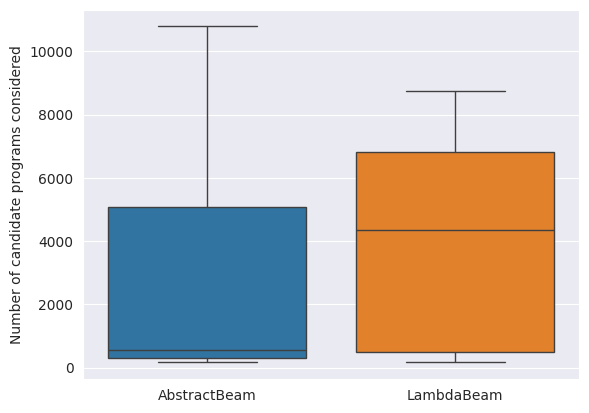

In [42]:
df = pd.DataFrame.from_dict({"AbstractBeam": df_ab["Number of candidate programs considered"], "LambdaBeam": df_lb["Number of candidate programs considered"]})
res = ttest(df["AbstractBeam"], df["LambdaBeam"])
print(res)
ax = plt.subplot()
sns.boxplot(df, ax=ax, showfliers=False)
ax.set_ylabel("Number of candidate programs considered")
# save_plot(plot_path + "boxplot_programs", plt.gcf())

In [27]:
def process_data_over_length(path, key="success"):
    with open(path) as f:
                results = json.load(f)["results"]
    if key == "success":
        success = np.array([sol["success"] if sol["success"] and sol["elapsed_time"] <= 100 else False for sol in results]) * 100
        x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results]
        df_ab = pd.DataFrame.from_dict({"Solution Weight": x_axis, "Success Rate [%]": success})
        key = "Success Rate [%]"
    elif key == "Abstraction usage [%]":
        sols = [sol for sol in results if sol["solution"] and sol["elapsed_time"] <= 100] 
        abs_used = np.array([True if "fn_" in str(sol["solution"]) else False for sol in sols]) * 100
        x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in sols]
        df_ab = pd.DataFrame.from_dict({"Solution Weight": x_axis, "Abstraction usage [%]": abs_used})
    elif key == "Elapsed Time":
        success = np.array([sol["elapsed_time"] if sol["success"] and sol["elapsed_time"] <= 100 else False for sol in results]) * 100
        x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results]
        df_ab = pd.DataFrame.from_dict({"Solution Weight": x_axis, "Elapsed Time": success})
    else:
        success = np.array([str(sol["solution"]).count("fn_") for sol in results if sol["solution"] and sol["elapsed_time"] <= 100])
        x_axis = [solution_weight(sol["task_solution"], domain=ckpt["domain"]) for sol in results if sol["solution"]]
        df_ab = pd.DataFrame.from_dict({"Solution Weight": x_axis, "Average Number of Used Abstractions": success})
    
    bins = np.arange(5, 17, 3)
    bined_df_ab = {"Maximum Program Length": [], key: []}
    for i in range(0, len(bins) - 1):
        min, max = bins[i], bins[i+1]
        filtered_df = df_ab[(df_ab["Solution Weight"] >= min) & (df_ab["Solution Weight"] < max)]
        bined_df_ab["Maximum Program Length"].append(max)
        bined_df_ab[key].append(filtered_df[key].mean())
    bined_df_ab = pd.DataFrame.from_dict(bined_df_ab)
    return bined_df_ab

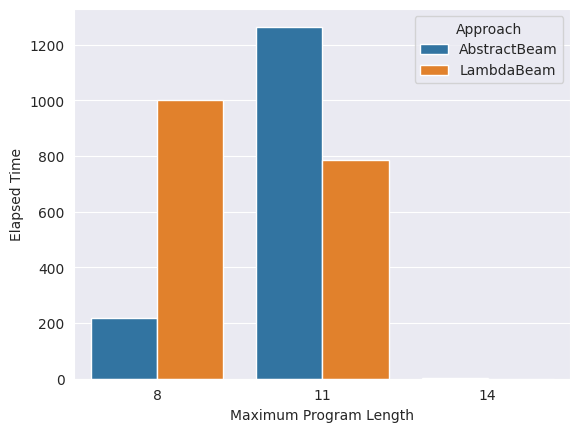

In [43]:
bined_df_ab = process_data_over_length("../neurips/abstractbeam/results/run_1.json", key="Elapsed Time")
bined_df_lb = process_data_over_length("../neurips/lambdabeam/results/run_1.json", key="Elapsed Time")

df_merged = pd.concat([bined_df_ab, bined_df_lb], keys=['AbstractBeam', 'LambdaBeam']).reset_index()
df_merged.drop(columns="level_1", inplace=True)
df_merged.rename(columns={'level_0': 'Approach'}, inplace=True)

ax = plt.subplot()
sns.barplot(df_merged, x="Maximum Program Length", y="Elapsed Time", hue="Approach", ax=ax)
# save_plot(plot_path + "time_programlength", plt.gcf())

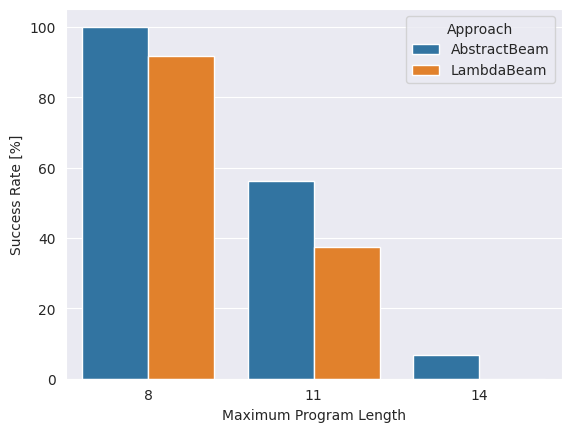

In [44]:
bined_df_ab = process_data_over_length("../neurips/abstractbeam/results/run_1.json")
bined_df_lb = process_data_over_length("../neurips/lambdabeam/results/run_1.json")

df_merged = pd.concat([bined_df_ab, bined_df_lb], keys=['AbstractBeam', 'LambdaBeam']).reset_index()
df_merged.drop(columns="level_1", inplace=True)
df_merged.rename(columns={'level_0': 'Approach'}, inplace=True)

ax = plt.subplot()
sns.barplot(df_merged, x="Maximum Program Length", y="Success Rate [%]", hue="Approach", ax=ax)
# save_plot(plot_path + "performance_programlength", plt.gcf())

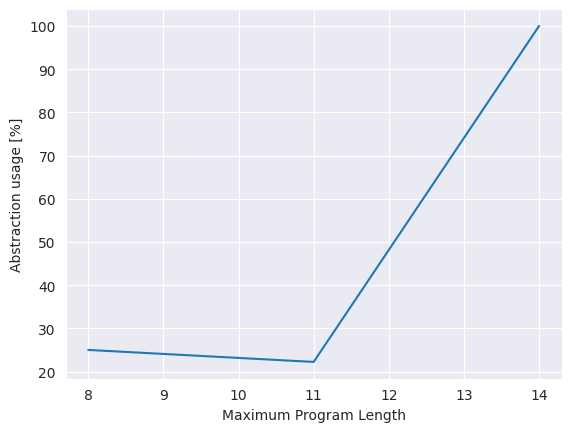

In [45]:
bined_df_ab = process_data_over_length("../neurips/abstractbeam/results/run_1.json", "Abstraction usage [%]")

ax = plt.subplot()
sns.lineplot(bined_df_ab, x="Maximum Program Length", y="Abstraction usage [%]", ax=ax, errorbar=None)
# save_plot(plot_path + "abstraction_usage", plt.gcf())

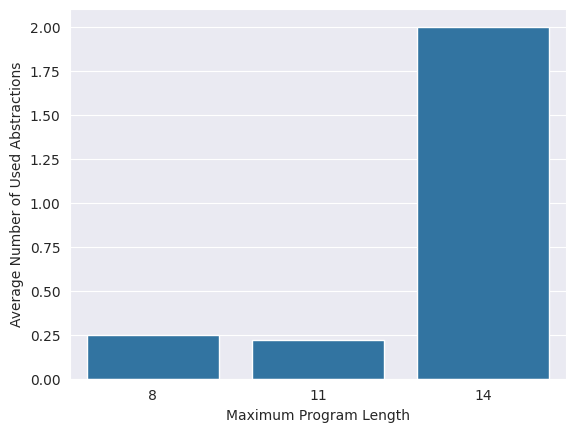

In [46]:
bined_df_ab = process_data_over_length("../neurips/abstractbeam/results/run_1.json", "Average Number of Used Abstractions")

ax = plt.subplot()
sns.barplot(bined_df_ab, x="Maximum Program Length", y="Average Number of Used Abstractions", ax=ax, errorbar=None)
# save_plot(plot_path + "abstractionusage_programlength", plt.gcf())

In [36]:
[(inv.name, inv.program) for inv in ckpt["inventions"]] + [('0', '0')]

[('fn_0', 'Count((lambda v1: Less(v1, x1)), x2)'),
 ('fn_1', 'x1(Min(Add(1, 1), x2))'),
 ('fn_3', 'Add(-1, x1)'),
 ('fn_5', 'Count((lambda v1: Equal(v1, x1)), x2)'),
 ('fn_6', 'x1(Min(fn_3(1), x2))'),
 ('fn_8', 'x1(Min(0, x2))'),
 ('fn_14', 'x1(0, x2)'),
 ('0', '0')]

In [37]:
sols = [sol["solution"] for sol in solutions if sol["solution"] and "fn_" in str(sol["solution"]) or "0" in str(sol["solution"])]
invs = [inv.name for inv in ckpt["inventions"]] + ['0']
count = {inv: 0 for inv in invs}
for inv in invs:
    for sol in sols:
        if str(inv) in str(sol):
            count[inv] += 1
count  

{'fn_0': 1,
 'fn_1': 0,
 'fn_3': 2,
 'fn_5': 3,
 'fn_6': 0,
 'fn_8': 0,
 'fn_14': 0,
 '0': 5}

In [38]:
path = "../neurips/abstractbeam/results/run_1.json"
with open(path) as f:
    results_ab = json.load(f)["results"]

path = "../neurips/lambdabeam/results/run_1.json"
with open(path) as f:
    results_lb = json.load(f)["results"]

for i in range(len(results_ab)):
    if results_ab[i]["success"] and not results_lb[i]["success"]:
        print(f"AbstractBeam solved: {results_ab[i]['solution']}, {results_ab[i]['task_solution']}")
        matches = re.findall('fn_\d+|0', results_ab[i]['solution'])
        if len(matches) > 0:
            print(rf"used abstraction(s): {matches}")
    if not results_ab[i]["success"] and results_lb[i]["success"]:
        print(f"LambdaBeam solved: {results_lb[i]['solution']}, {results_lb[i]['task_solution']}")

AbstractBeam solved: Scanl1((lambda u1, u2: ((lambda v1: Access(v1, x)))(u1)), x), Scanl1((lambda u1, u2: Access(u1, x)), x)
AbstractBeam solved: fn_5(Access(i, x), x), Count((lambda u1: Equal(u1, Access(i, x))), x)
used abstraction(s): ['fn_5']
AbstractBeam solved: Add(fn_5(0, x), fn_5(0, y)), Add(Count((lambda u1: Equal(u1, 0)), x), Count((lambda u1: Equal(u1, 0)), y))
used abstraction(s): ['fn_5', '0', 'fn_5', '0']
LambdaBeam solved: Map((lambda u1: ((lambda v1: If(((lambda v1: Greater(v1, -1)))(v1), v1, y)))(u1)), x), Map((lambda u1: If(Less(u1, 0), y, u1)), x)
AbstractBeam solved: Map((lambda u1: ((lambda v1: fn_3(((lambda v1: Square(((lambda v1: Add(v1, 1)))(v1))))(v1))))(u1)), x), Map((lambda u1: Multiply(u1, Add(u1, 2))), x)
used abstraction(s): ['fn_3']
LambdaBeam solved: Take(-1, Scanl1((lambda u1, u2: ((lambda v1, v2: Min(v1, v2)))(u2, u1)), Drop(1, x))), Scanl1((lambda u1, u2: Min(u1, u2)), Take(-1, Drop(1, x)))
AbstractBeam solved: ZipWith((lambda u1, u2: ((lambda v1, v2: 